In [ ]:
 try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    #!git clone https://github.com/mjwock/DeepFLaSH_Pytorch.git /content/drive/My\ Drive/FastAI_Microscopy_Segmentation
    %cd /content/drive/My\ Drive/FastAI_Microscopy_Segmentation
    #!git pull
except:
    pass

Mounted at /content/drive
/content/drive/My Drive/DeepFLaSH_Pytorch/FastAI2


In [ ]:
!pip install elasticdeform

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 
%tensorflow_version 1.x

import os
import pandas as pd
import matplotlib.pyplot as plt

from fastai.callbacks import SaveModelCallback


from torch import nn
from torchsummary import summary
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, matthews_corrcoef, fbeta_score, jaccard_score
import warnings

from datetime import datetime
from ipywidgets import widgets

from deepflash import unetadaption, utility
from deepflash.fastai_extension import *

TensorFlow 1.x selected.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# SETTINGS

Load a previous model


In [ ]:
LOAD_MODEL = None   # Path to model .pkl file, else 'None'

General Params

In [ ]:
DIR = '/content/drive/My Drive/FastAI_Microscopy_Segmentation/data'    
                          # parent directory for data

IMAGE_TYPE = 'L'          # 'L' for greyscale, 'RGB'for color, 'P' for palette images

TILE_SHAPE = (540,540)    # desired input size for conv network (e.g. (540,540))
MASK_SHAPE = (356,356)    # Check the 'Network Summary' section below for last layer output shape

SEED = 42

In [ ]:
# CHANGE FOR DIFFERENT FOLDER STRUCTURE
IMG_PATH = f'{DIR}/images/NucleusSegData/'
MASK_PATH = f'{DIR}/temp_data/transfer_labels/'
WEIGHT_PATH = f'{DIR}/temp_data/transfer_weights/'

# DON'T CHANGE
PADDING = tuple(np.subtract(TILE_SHAPE,MASK_SHAPE))

Network Params

In [ ]:
IN_CHANNELS = 1   # dependent on IMAGE_TYPE : 1 if 'L' or 'P', 3 if 'RGB'
N_CLASSES = 2     # number of classes

CLASSES = ['background','cell'] # [0,1]

# SHOULD NOT BE CHANGED
DEPTH = 5
BATCH_NORM = True # batch normalization after first layer
DROPOUT = 0.5     # Dropout Sampling drawn from Bernoulli with probability of DROPOUT, else 'None'
LEAKY = 0.1       # slope of the leaky ReLU, '0' for regular ReLU

Training Params

In [ ]:
BATCH_SIZE = 6          # batch size should be set as high as possible, 
                            # but must be smaller than the number of training images.
N_SPLITS = 6            # train-validation split (1/N_SPLITS for validation)

CSV_LOG = True          # logs error and loss in an additional CSV file

Transformations

In [ ]:
DEFORMATION = True          # elastic deformation

RAND_CROP = True            # random crop of image

ROTATION_MAX_ANGLE = 15     # max rotation in degrees

LIGHT_CONTRAST_CHANGE = 0.03  # max increase of brightness/contrast

TRANSFORM_VALID = False     # also transform validation dataset

xtra_tfms = None            # add extra transforms as list here, e.g. xtra_tfms = [jitter()]

## Network Summary


In [ ]:
net = unetadaption.UNet(in_channels=IN_CHANNELS,
                        n_classes=N_CLASSES,
                        depth=DEPTH,
                        padding=False,
                        batch_norm=BATCH_NORM,
                        dropout = DROPOUT,
                        leaky_slope=LEAKY)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = net.to(device)

summary(model, input_size=(IN_CHANNELS, TILE_SHAPE[0], TILE_SHAPE[1]))

# DATA

## Data Preparation

Retrieve images from folder

In [ ]:
filenames = os.listdir(IMG_PATH)

img_ids = [os.path.splitext(files)[0] for files in filenames] # get list with img_ids
imgExt = os.path.splitext(filenames[0])[1]                    # get image extension

In [ ]:
images = [img_name for img_name in [f'{s}{imgExt}' for s in img_ids]]
img_df = pd.DataFrame([Path(image) for image in images])

Function to map from image path to mask and weight paths

In [ ]:
### Change the regDigits expression if filenames include special characters
regDigits = r'\w+'

maskExt = '.tif'
get_labels = lambda x: Path(f'{MASK_PATH}/{re.findall(regDigits,Path(x).stem)[0]}{maskExt}')
get_weights = lambda x: Path(f'{WEIGHT_PATH}/{re.findall(regDigits,Path(x).stem)[0]}{maskExt}')

Show example image, labels and weights

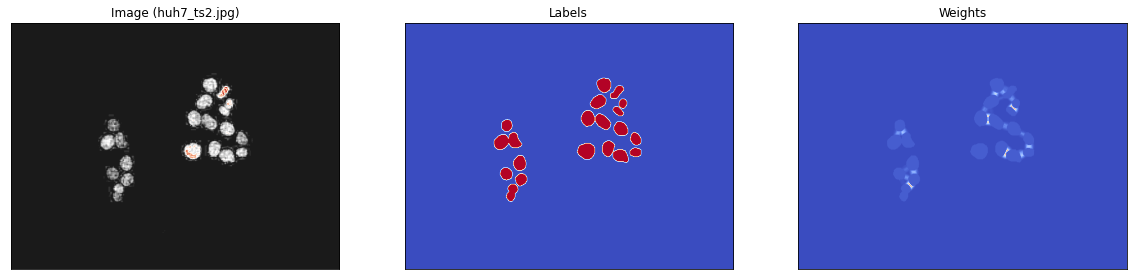

In [ ]:
# cmap can be either string or list of strings
utility.show_example_data_batch(IMG_PATH,img_df,get_labels,get_weights,cmap=('RdGy_r','coolwarm','coolwarm'), n=1)

## Transformations

Elastic Deformation Magnitude <br>
(with standard deviation SIGMA and gridpoint count GRID_DIVS)

In [ ]:
SIGMA = 12              # standard deviation of elastic deformation
GRID_DIVS = 3           # number of grid divisions

BORDER_MODE = 'mirror'  #(nearest, wrap, reflect, mirror, constant)

Calculate the range of center coordinates for random crop

In [ ]:
# gets original size of raw images
original_size = utility.get_image_size(f'{IMG_PATH}/{img_ids[0]}{imgExt}')

# min distance from any border of the image in percent (tuple for x and y):
row_col_per = np.divide(np.add(np.multiply(0.5,TILE_SHAPE),1),original_size)

# ranges for row_pct and col_pct for initial_crop_pad(**rand_pos):
rand_pos = {'row_pct':(row_col_per[0],1-row_col_per[0]), 'col_pct':(row_col_per[1],1-row_col_per[1])}

Visualization of deformation grid

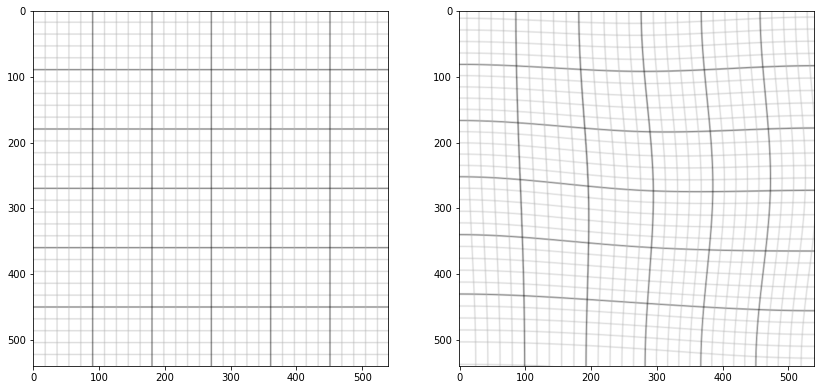

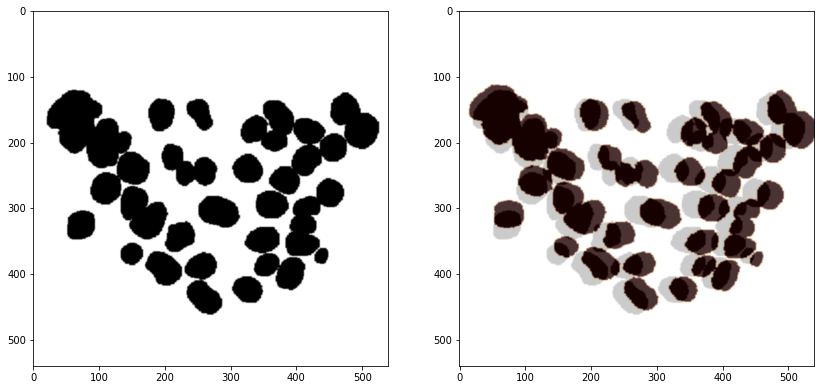

In [ ]:
example_img1 = io.imread(get_labels(img_ids[2]))

utility.test_deformation(shape=TILE_SHAPE,sigma=SIGMA,points=GRID_DIVS, seed=SEED)
utility.test_deformation(shape=TILE_SHAPE,example_img=example_img1, sigma=SIGMA,points=GRID_DIVS, seed=SEED)

**Custom 'get_transforms()' function for selected augmentations**

Transforms are generally applied on train set only, but this can be changed with 'transform_valid_ds = True'. Standard transforms on train set include: 

*   randomly mirror image on x- and y-axis
*   light brightness and contrast increase
*   random rotation
*   elastic deformation





In [ ]:
tfms = get_custom_transforms(elastic_deformation= DEFORMATION,
                             elastic_deform_args= {'sigma':SIGMA, 'points':GRID_DIVS, 'mode':BORDER_MODE},
                             random_crop= TILE_SHAPE if RAND_CROP else None,
                             rand_pos= rand_pos, 
                             max_lighting= LIGHT_CONTRAST_CHANGE,
                             max_rotate= ROTATION_MAX_ANGLE,
                             p_deformation = 0.95,
                             p_affine = .075,
                             p_lighting = 0.5,
                             transform_valid_ds= TRANSFORM_VALID,
                             xtra_tfms = xtra_tfms
                             )

## Data Loading

**Create databunch object**

In [ ]:
data = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode=IMAGE_TYPE)
      # import from df in grayscale
      .split_by_rand_pct(valid_pct=(1/N_SPLITS),seed=SEED)
      # 1/10 random train/validation split
      .label_from_funcs(get_labels, get_weights, target_size=MASK_SHAPE, classes = array(CLASSES))
      # segmentation labels and weights
      .transform(tfms=tfms, tfm_y=True)
      # apply data augmentation
      .databunch(bs=BATCH_SIZE)
      # set batchsize
)

Masks will be cropped to (356, 356). Choose 'target_size = None' to keep initial size.
Masks will be cropped to (356, 356). Choose 'target_size = None' to keep initial size.


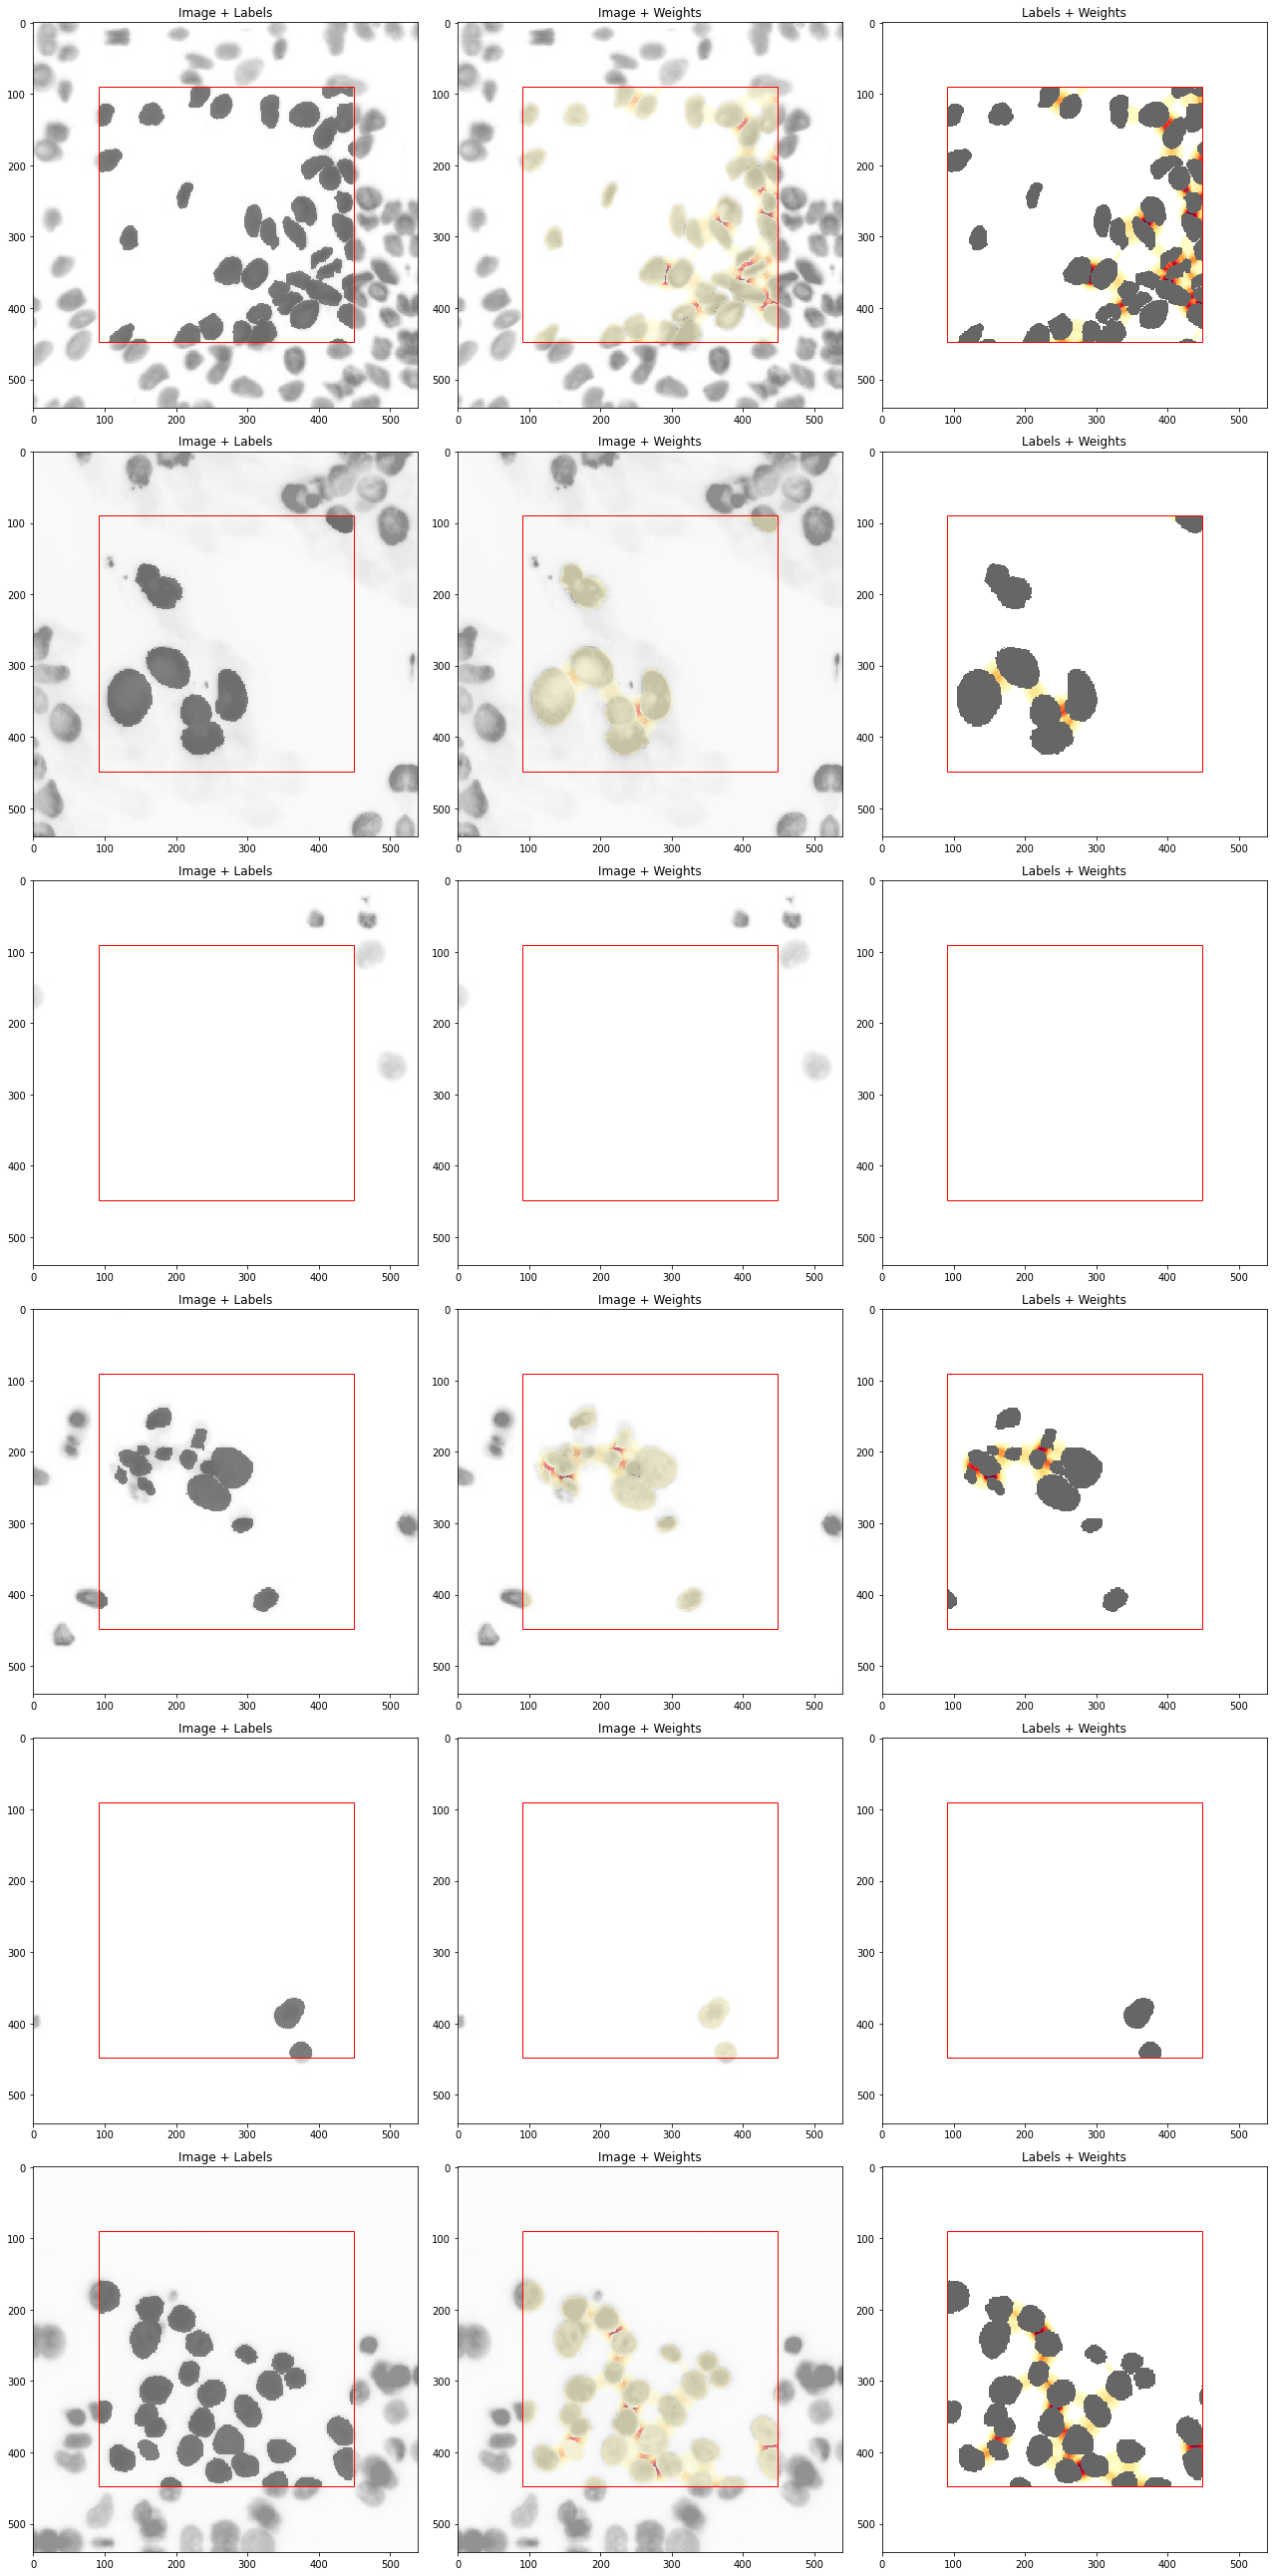

In [ ]:
data.show_batch()

 # TRAINING

## Prerequisites

In [ ]:
TRAINING_NAME = 'new_9'

In [ ]:
# set identifier for this training as name + datetime in yymmdd_HHMM-format
date_format = '%y%m%d_%H%M'
run_folder = f'{TRAINING_NAME}_{datetime.today().strftime(date_format)}'

Metrics <br>
<i> Add new metric funcs to list, wrapped in 'CustomMetrics' class, swap preds and target values if needed. Place additional keyword arguments for func inside of custom metrics. </i>

In [ ]:
metrics_list = [CustomMetrics(matthews_corrcoef,name='mcc'),
                CustomMetrics(jaccard_score, name='IoU'),
                CustomMetrics(fbeta_score,name='F0.5', beta=0.5)]

Which metric should be used to define the best epoch?

In [ ]:
METRIC = 'IoU' # Monitored metric can be changed to any from 'metrics_list"

Initiate Kfold

In [ ]:
kfold = KFold(N_SPLITS, True, SEED)

Learner <br>
<p><i>Initiation of the learner initiator. All cycle independent base information is passed here. A new learner instance is then created by calling 'learner_initiator' with data, cycle countand weight decay. </i> "./model/rund_folder". </p>

In [ ]:
model_dir = f'{DIR}/model/{run_folder}'

learner_initiator = initiate_learn(model_dir,
                                   net,
                                   metrics_list,
                                   WeightedCrossEntropyLoss(axis=1, reduction_mode='mean'),
                                   torch.optim.Adam,
                                   CSV_LOG)

In [ ]:
cycle = 0

learn = learner_initiator(data,cycle)

if LOAD_MODEL:
  learn = load_learner(LOAD_MODEL,'')
  learn.model_dir = f'{model_dir}'

learn.save(f'{cycle}/temp_model') # save initial weights to folder 0

cycle += 1

Cycle 0 directory created.


# Iterative Training Cycle

Settings

In [ ]:
WEIGHT_DECAY = 10e-02
KFOLD = False               # trials indicate that an initial k-fold does not seem to be necessary
DISCRIMINATIVE_LR = False   # enable if single LR inputs should be converted to discriminative LR ranges
EARLY_STOPPING = 'mcc'      # enable early stopping if given metric doesn't improve, else 'None' or 'False'

Initiate New Learner

In [ ]:
learn = learner_initiator(data,cycle,WEIGHT_DECAY,early_stopping=EARLY_STOPPING)

utility.blockPrint()
learn.load(f'{cycle-1}/temp_model')
learn.split(utility.split_net)
utility.enablePrint()

In [ ]:
FREEZE = 0                   # [0, 1, 2] for unfreeze, freeze down-path and freeze until last layer

learn.freeze_to(FREEZE)

Learning Rate Finder

In [ ]:
learn.lr_find(end_lr=10)
learn.recorder.plot()

Chose LR

In [ ]:
MAX_LEARNING_RATE = utility.chose_lr(DISCRIMINATIVE_LR)

# for initial training, a high number of epochs should be used (75-150)
INITIAL_EPOCHS = utility.chose_n_epochs()

Chose learning rate(s) (e.g. '1e-04' or '1e-04,1e-03'): 
1e-02
Number of training epochs: 
75


Training

In [ ]:
if KFOLD:

  count = 0
  for train, test in kfold.split(img_df):
    
    #load initiation weights and freeze model
    utility.blockPrint()
    learn = learner_initiator(data,cycle,WEIGHT_DECAY,f'metrics_{count}')
    learn.load(f'{cycle-1}/temp_model')
    learn.split(utility.split_net)
    learn.freeze_to(FREEZE)

    #load data for this fold
    data = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode=IMAGE_TYPE)
        .split_by_idxs(train_idx=train, valid_idx=test)
        .label_from_funcs(get_labels, get_weights, target_size=MASK_SHAPE, classes = array(CLASSES))
        .transform(tfms=tfms, tfm_y=True)
        .databunch(bs=BATCH_SIZE)
    )
    utility.enablePrint()

    #change train and valid data
    learn.data = data

    learn.fit_one_cycle(INITIAL_EPOCHS,
                        max_lr=MAX_LEARNING_RATE,
                        callbacks=[SaveModelCallback(learn, every='improvement', monitor=METRIC, name=f'{cycle}/temp_model_{count}')])
                        
    learn.recorder.plot_metrics()

    learn.purge()
    learn.destroy()

    count += 1

else:
  learn.fit_one_cycle(INITIAL_EPOCHS,
                      max_lr=MAX_LEARNING_RATE,
                      callbacks=[SaveModelCallback(learn, every='improvement', monitor=METRIC, name=f'{cycle}/temp_model')])

  learn.save(f'{cycle}/temp_model')

  learn.recorder.plot_metrics()

  learn.purge()
  learn.destroy()

In [ ]:
cycle = utility.save_cycle(model_dir,cycle,KFOLD)

Should this run be saved? (y/n): 
y


# EVALUATION

Save Model

In [ ]:
learn = learner_initiator(data,cycle,WEIGHT_DECAY)
learn.load(f'{cycle-1}/temp_model')
learn.unfreeze()

learn.export(f'{model_dir}/final_model.pkl')

Load Model

In [ ]:
LOAD_MODEL_EVAL_DIR = None      # load model for evaluation (path to directory here, else 'None') 
MODEL_NAME = 'final_model.pkl'  # name of model
SAVE_METRICS = True             # save metrics to directory

if LOAD_MODEL_EVAL_DIR:
  learn = load_learner(LOAD_MODEL_EVAL_DIR,MODEL_NAME)
  model_dir = f'{LOAD_MODEL_EVAL_DIR}'
else:
  learn = load_learner(f'{model_dir}',MODEL_NAME)

Load Test Data

In [ ]:
TEST_IMAGES = '/content/drive/My Drive/FastAI_Microscopy_Segmentation/data/images/NucleusSegData'
TEST_LABELS = '/content/drive/My Drive/FastAI_Microscopy_Segmentation/data/temp_data/transfer_labels'

images, labels, names = utility.load_images_and_labels(TEST_IMAGES,TEST_LABELS)

## TileGenerator
<br><p>
The tile generator handles the division of large input images into smaller tiles. It can be fed with diverse forms of images, having different shapes. It is given a list of Image files and a learner object. </p>
<i>.predict_all()</i> predicts all tiles <br>
<i>.stitch_results()</i> stitches them back together and returns a list of predictions and one with their pixelwise probabilities 

In [ ]:
# initiate TileGenerator instance
tyler = TileGenerator(images,learn, TILE_SHAPE, MASK_SHAPE)

In [ ]:
tyler.predict_all()

In [ ]:
# returns a list of images for results and their probabilities
results, probabilities = tyler.stitch_results()

## Metrics Evaluation

In [ ]:
METRICS = [partial(fbeta_score, beta=0.5),    # Which metrics should be used to analyze the prediction, append list if needed
           matthews_corrcoef,
           jaccard_score]

In [ ]:
evaluator = utility.evaluator(results,labels,METRICS)

In [ ]:
# return all metrics in a DataFrame
evaluator()

,mean,std,var
fbeta_score,0.928361,0.026542,0.000704
matthews_corrcoef,0.912862,0.025772,0.000664
jaccard_score,0.851965,0.038904,0.001514


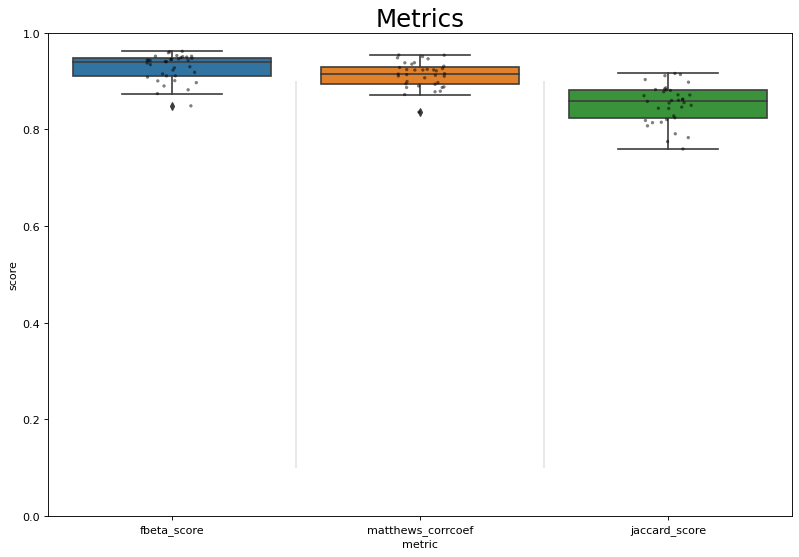

In [ ]:
# Boxplot all metrics
evaluator.boxplot()

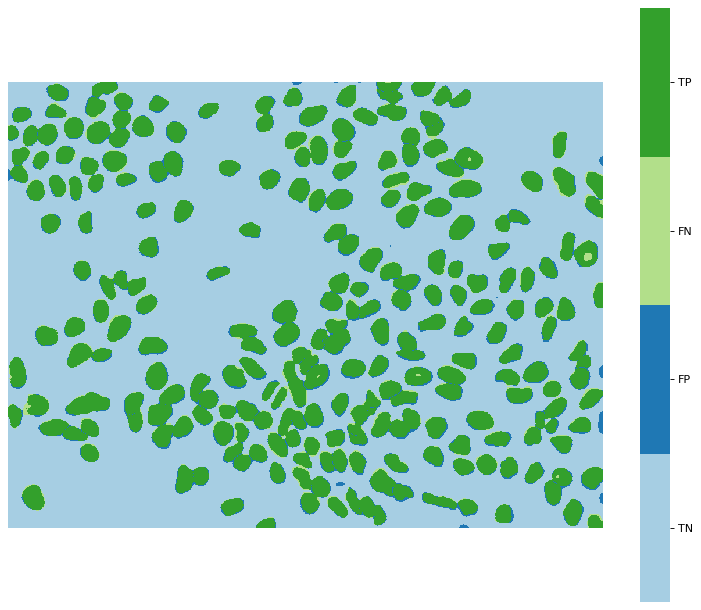

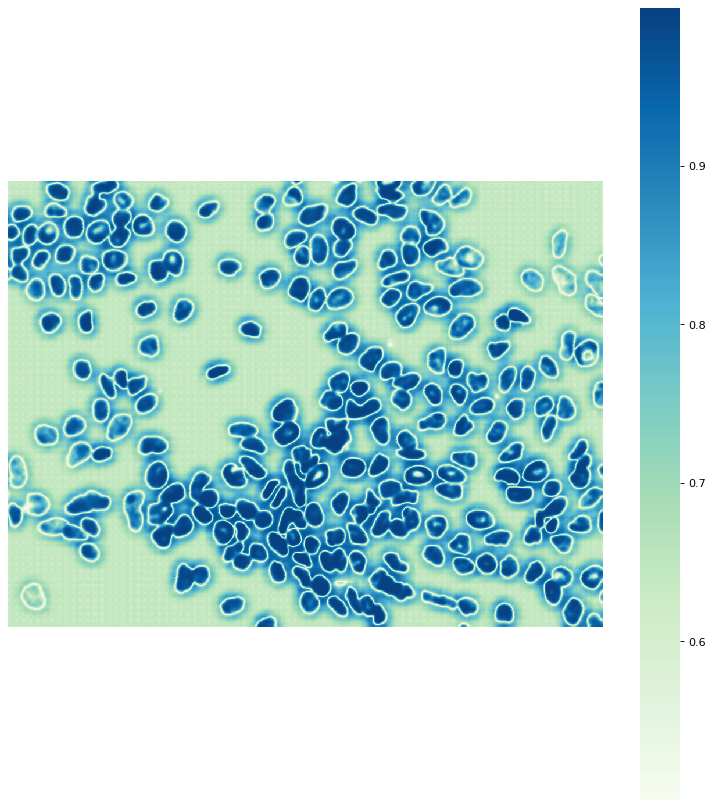

In [ ]:
EXAMPLE_ID = 2
evaluator.plot_conf_map(EXAMPLE_ID)
evaluator.plot_prob_map(probabilities[EXAMPLE_ID])

In [ ]:
if SAVE_METRICS:
  evaluator.save_to_csv(model_dir)

##Object Based Evaluation

In [ ]:
obj_acc = utility.object_based_accuracy(results,labels)

In [ ]:
# recalculate metrics by changing values for IoU threshold or the cell size threshold
obj_acc.reconfigure_matches(iou_thresh=0.5,size_thresh=0)

In [ ]:
 # return all metrics in a DataFrame
obj_acc()

,mean,std,var
precision,0.641089,0.279963,0.078379
recall,0.903427,0.110610,0.012235
F1,0.715456,0.254230,0.064633


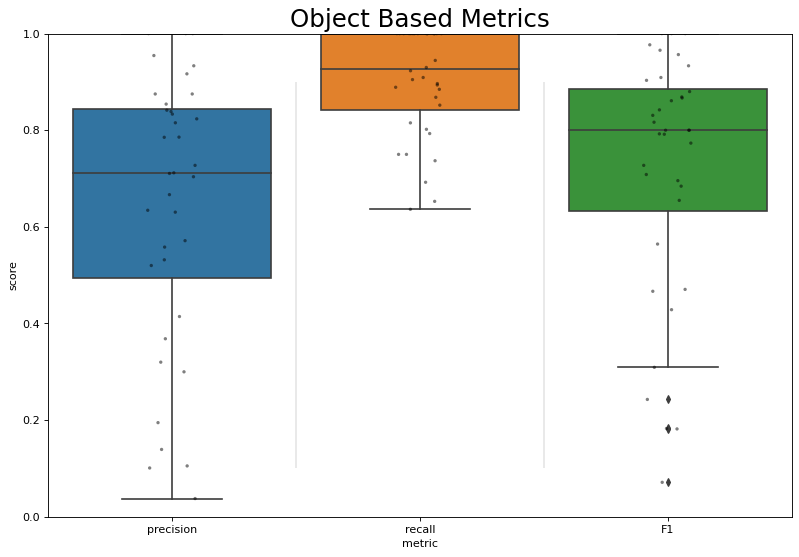

In [ ]:
# Boxplot object wise recall, precision and F_Beta
obj_acc.boxplot()

In [ ]:
if SAVE_METRICS:
  obj_acc.save_to_csv(model_dir)

## Inter Coding Reliability

In [ ]:
CODER_DIRECTORY = '/content/drive/My Drive/DeepFLaSH_Pytorch/FastAI2/data/labels/cFOS'
EXPERTS = ['gt','cora','corinna','dennis','manju','rohini']

In [ ]:
inter_coding = utility.inter_coding_reliability(results,CODER_DIRECTORY,EXPERTS,names)

In [ ]:
inter_coding(jaccard_score)

In [ ]:
# plot results in a table
inter_coding.plot_results(anon=True)

In [ ]:
if SAVE_METRICS:
  obj_acc.save_to_csv(model_dir)